In [1]:
!pip install scikit-learn xgboost lightgbm catboost

In [35]:
import sklearn
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, f1_score
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

In [36]:
df = pd.read_excel('./Confocal Raman Data/Subjects Components Filtered.xlsx')

In [50]:
df

,Healthy/Eczema,Subject,Ceramide 2,Ceramide 3,Lactic Acid,PCA,Uric Acid,Urea,Melanin,Cholesterol,Watermass
0,Eczema,EC001,0.000000,0.120289,0.026488,0.060566,0.000749,0.021031,2.230477,0.000000,43709.818546
1,Eczema,EC002,0.000000,0.110608,0.086276,0.040751,0.000102,0.013240,0.037265,0.001449,50761.610963
2,Eczema,EC003,0.000000,0.146709,0.051836,0.073384,0.000108,0.008633,2.728881,0.001867,39431.720135
3,Eczema,EC004,0.000000,0.306053,0.229205,0.264416,0.006567,0.024359,12.517264,0.000000,24836.572041
4,Eczema,EC006,0.000000,0.270734,0.129418,0.070845,0.000929,0.005694,0.733396,0.003287,76318.466566
...,...,...,...,...,...,...,...,...,...,...,...
71,Healthy,H046,0.000000,0.331470,0.144327,0.103408,0.002034,0.054572,1.730375,0.006811,13379.936053
72,Healthy,H047,0.000000,0.347538,0.123235,0.147987,0.001989,0.024887,1.021039,0.010425,7524.435836
73,Healthy,H048,0.026054,0.236214,0.042040,0.046963,0.004684,0.009837,0.000000,0.007840,12533.452496
74,Healthy,H049,0.000000,0.246170,0.079999,0.113140,0.002050,0.040404,2.954459,0.002814,10455.569270


In [51]:
df['class'] = 1

In [52]:
df.loc[df['Healthy/Eczema'] == 'Healthy', 'class'] = 0

In [7]:
df = df.drop('Healthy/Eczema', axis=1)
df = df.drop('Subject', axis=1) # Dropping useless columns

In [8]:
df = df.sample(frac=1).reset_index(drop=True)
X = df.iloc[:, :-1]
y = df.iloc[:, -1] # Setting X and y

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15) # Train test split for CV

In [62]:
classifiers = {
    'Random Forest': (RandomForestClassifier(), {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']
    }),
    'K-Nearest Neighbors': (KNeighborsClassifier(), {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree']
    }),
    'Decision Tree': (DecisionTreeClassifier(), {
        'max_depth': [None, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']
    }),
    'AdaBoost': (AdaBoostClassifier(), {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.1, 0.01, 0.001]
    }),
    'XGBoost': (xgb.XGBClassifier(), {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.1, 0.01, 0.001],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
    }),
    'LightGBM': (lgb.LGBMClassifier(), {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.1, 0.01, 0.001],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
    }),
    'CatBoost': (CatBoostClassifier(silent=True), {
        'iterations': [50, 100, 200],
        'learning_rate': [0.1, 0.01, 0.001],
        'depth': [3, 5, 7],
    }),
}


In [33]:
!pip install scikit-optimize

     -------------------------------------- 100.3/100.3 kB 2.9 MB/s eta 0:00:00


In [ ]:
import skopt
from skopt import BayesSearchCV
for clf_name, (clf, param_bayes) in classifiers.items():
    bayes_search = BayesSearchCV(clf, param_bayes, cv=5)
    bayes_search.fit(X_train, y_train)

    best_score = bayes_search.best_score_
    best_params = bayes_search.best_params_ 

    print(f"Results for {clf_name}:")
    print("Best cross-validation accuracy:", best_score)
    print("Best hyperparameters:", best_params)
    print("-----------------------------------")
    
    best_model = bayes_search.best_estimator_
    test_score = best_model.score(X_test, y_test)
    print("Test accuracy:", test_score)
    print("-----------------------------------")
    
    y_pred = best_model.predict(X_test)
    print(sklearn.metrics.classification_report(y_test, y_pred))


C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\

Results for Random Forest:
Best cross-validation accuracy: 0.6871794871794872
Best hyperparameters: OrderedDict([('max_depth', 5), ('max_features', 'sqrt'), ('min_samples_leaf', 4), ('n_estimators', 50)])
-----------------------------------
Test accuracy: 0.6666666666666666
-----------------------------------
              precision    recall  f1-score   support

           0       0.91      0.88      0.89        33
           1       0.91      0.93      0.92        43

    accuracy                           0.91        76
   macro avg       0.91      0.90      0.91        76
weighted avg       0.91      0.91      0.91        76



C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\

Results for K-Nearest Neighbors:
Best cross-validation accuracy: 0.7179487179487178
Best hyperparameters: OrderedDict([('algorithm', 'kd_tree'), ('n_neighbors', 7), ('weights', 'distance')])
-----------------------------------
Test accuracy: 0.75
-----------------------------------
              precision    recall  f1-score   support

           0       0.94      0.97      0.96        33
           1       0.98      0.95      0.96        43

    accuracy                           0.96        76
   macro avg       0.96      0.96      0.96        76
weighted avg       0.96      0.96      0.96        76



C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\

In [64]:
from sklearn.model_selection import StratifiedKFold

estimators = [(name, clf) for name, (clf, _) in classifiers.items()]
stacking_clf = StackingClassifier(estimators=estimators)
stacking_clf.fit(X_train, y_train)

StackingClassifier(estimators=[('Random Forest', RandomForestClassifier()),
                               ('K-Nearest Neighbors', KNeighborsClassifier()),
                               ('Decision Tree', DecisionTreeClassifier()),
                               ('AdaBoost', AdaBoostClassifier()),
                               ('XGBoost',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              early_stopping_roun...
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              n_estimators=100, n_jobs=None,
                                              num_parallel_tree=None,
                                              predictor=None, random_state=None, ...)),
                               ('LightGBM', LGBMClassifier()),
                               ('CatBoost',
                                <catboost.core.CatBoostClassifier object at 0x0000021A2C7D0F70>)])

In [65]:
bagging_clf.fit(X_train, y_train) 

C:\Users\Mahir\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=100)

In [66]:
y_pred = bagging_clf.predict(X_test)
print(sklearn.metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      1.00      0.86         6
           1       1.00      0.67      0.80         6

    accuracy                           0.83        12
   macro avg       0.88      0.83      0.83        12
weighted avg       0.88      0.83      0.83        12



In [67]:
y_pred = stacking_clf.predict(X_test)
print(sklearn.metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      1.00      0.86         6
           1       1.00      0.67      0.80         6

    accuracy                           0.83        12
   macro avg       0.88      0.83      0.83        12
weighted avg       0.88      0.83      0.83        12



In [71]:
feature_importances = np.mean([
    tree.feature_importances_ for tree in bagging_clf.estimators_
], axis=0)

In [72]:
import seaborn as sns

<Axes: title={'center': 'Feature Importance of Bagging Classifier'}, xlabel='Features', ylabel='Feature Importance'>

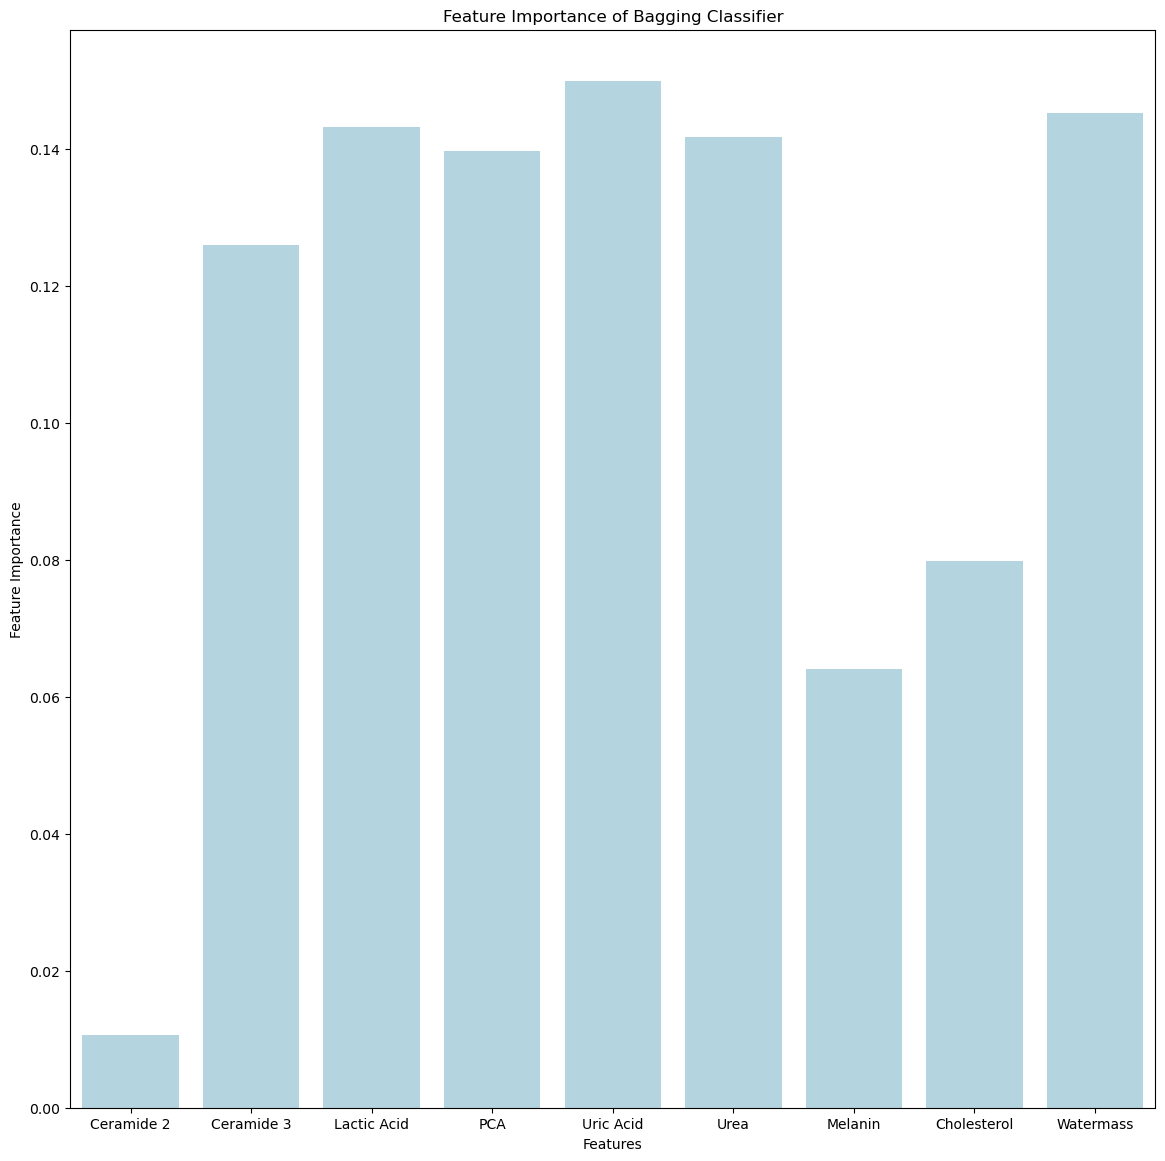

In [78]:
import matplotlib.pyplot

plt.figure(figsize=(14, 14))
plt.xlabel('Features')
plt.ylabel('Feature Importance')
plt.title('Feature Importance of Bagging Classifier')
sns.barplot(y=feature_importances, x=X.columns, color='b', palette=['lightblue'])